# Tensorflow Object Detection API TF->TRT Model and Inference Demo

This notebook explains the process for optimizing a tensorflow model to TensorRT, it is simple but let's dive in.

### Import some packages

At this point just importing some neccesary packages and later we will install our support packages, also we check the tensorflow version

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
import tensorflow as tf
import sys
import os
import tensorflow.contrib.tensorrt as trt
from google.colab import drive
import time

tf.__version__

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



'1.15.2'

### Paths, Paths, Paths

Mostly, the problem of all libraries are paths. Usually PATH variable is more general but you can create any path.

In [3]:
syspath = sys.path
pythonpath = os.environ['PYTHONPATH']

print(f'System Path = {syspath}')
print(f'PythonPath  = {pythonpath}')

System Path = ['/tensorflow-1.15.2/python3.6', '', '/env/python', '/usr/lib/python36.zip', '/usr/lib/python3.6', '/usr/lib/python3.6/lib-dynload', '/usr/local/lib/python3.6/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.6/dist-packages/IPython/extensions', '/root/.ipython']
PythonPath  = /tensorflow-1.15.2/python3.6:/env/python


In [4]:
sys.path.append('/content/models/research')
sys.path.append('/content/models/research/slim')

sys.path

['/tensorflow-1.15.2/python3.6',
 '',
 '/env/python',
 '/usr/lib/python36.zip',
 '/usr/lib/python3.6',
 '/usr/lib/python3.6/lib-dynload',
 '/usr/local/lib/python3.6/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.6/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content/models/research',
 '/content/models/research/slim']

### Instal TFOD API

Once again we will install TFOD API.

In [5]:
%cd /content
!apt-get install protobuf-compiler python-pil python-lxml python-tk
!pip install cython jupyter matplotlib tf_slim
!git clone https://github.com/tensorflow/models.git
%cd models/research
!protoc object_detection/protos/*.proto --python_out=.
!python setup.py build
!python setup.py install
%cd slim
!python setup.py build
!python setup.py install
%cd /content/models/research
!python object_detection/builders/model_builder_test.py
%cd /content

/content
Reading package lists... Done
Building dependency tree       
Reading state information... Done
protobuf-compiler is already the newest version (3.0.0-9.1ubuntu1).
python-tk is already the newest version (2.7.17-1~18.04).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  python-bs4 python-chardet python-html5lib python-olefile
  python-pkg-resources python-six python-webencodings
Suggested packages:
  python-genshi python-lxml-dbg python-lxml-doc python-pil-doc python-pil-dbg
  python-setuptools
The following NEW packages will be installed:
  python-bs4 python-chardet python-html5lib python-lxml python-olefile
  python-pil python-pkg-resources python-six python-webencodings
0 upgraded, 9 newly installed, 0 to remove and 33 not upgraded.
Need to get 1,818 kB of archives.
After this operation, 7,685 kB of additional disk space will be used.


### Append tf_trt_models path

Another path appending for the tf trt libraries

In [6]:
sys.path.append('/content/tf_trt_models/')

sys.path

['/tensorflow-1.15.2/python3.6',
 '',
 '/env/python',
 '/usr/lib/python36.zip',
 '/usr/lib/python3.6',
 '/usr/lib/python3.6/lib-dynload',
 '/usr/local/lib/python3.6/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.6/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content/models/research',
 '/content/models/research/slim',
 '/content/tf_trt_models/']

In [7]:
%cd /content
!apt-get install python-pip python-matplotlib python-pil
!git clone https://github.com/NVIDIA-AI-IOT/tf_trt_models.git
%cd tf_trt_models
!python setup.py build
!python setup.py install
%cd /content

/content
Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-pil is already the newest version (5.1.0-1ubuntu0.2).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  fonts-lyx javascript-common libjs-jquery libjs-jquery-ui libpython-all-dev
  python-all python-all-dev python-asn1crypto
  python-backports.functools-lru-cache python-cffi-backend python-crypto
  python-cryptography python-cycler python-dateutil python-dbus python-enum34
  python-gi python-idna python-ipaddress python-keyring python-keyrings.alt
  python-matplotlib-data python-pip-whl python-pyparsing python-secretstorage
  python-setuptools python-subprocess32 python-tz python-wheel python-xdg
  ttf-bitstream-vera
Suggested packages:
  apache2 | lighttpd | httpd libjs-jquery-ui-docs python-crypto-doc
  python-cryptography-doc python-cr

### Mount the drive

Mounting our google drive cloud storage

In [8]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Load the graph

[Therea are several ways to load a graph...](https://docs.nvidia.com/deeplearning/frameworks/tf-trt-user-guide/index.html)
- By checkpoints
- By frozen graph
- By Saved Model

Check the link above on section 2.1 to see more.

In [9]:
from tf_trt_models.detection import build_detection_graph

%cd /content/drive/My\ Drive/TensorflowObjectDetectionAPI/object_detection/
config_path     = 'config/ssd_mobilenet_v1_coco.config'
checkpoint_path = 'train/model.ckpt-6186'
score_threshold = 0.5
batch_size      = 1 

frozen_graph, input_names, output_names = build_detection_graph(
    config=config_path,
    checkpoint=checkpoint_path,
    score_threshold=score_threshold,
    batch_size=batch_size
)

/content/drive/My Drive/TensorflowObjectDetectionAPI/object_detection


Instructions for updating:
Please use `layer.__call__` method instead.
INFO:tensorflow:depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Please switch to tf.train.get_or_create_global_step
Instructions for updating:
Use `tf.profiler.profile(graph, run_meta, op_log, cmd, options)`. Build `options` with `tf.profiler.ProfileOptionBuilder`. See README.md for details
Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`


23 ops no flops stats due to incomplete shapes.
23 ops no flops stats due to incomplete shapes.


INFO:tensorflow:Restoring parameters from train/model.ckpt-6186
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from train/model.ckpt-6186
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 199 variables.
INFO:tensorflow:Converted 199 variables to const ops.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: .generated_model/saved_model/saved_model.pb
INFO:tensorflow:Writing pipeline config file to .generated_model/pipeline.config




### Print tensor names

For making inference we need that information

In [10]:
print(output_names)

['detection_boxes', 'detection_classes', 'detection_scores', 'num_detections']


In [11]:
print(input_names)

['image_tensor']


### Load the graph

Here we will load the trt graph.

In [12]:
# create the optimized TRT graph from 
# the frozen TensorFlow graph
trtGraph = trt.create_inference_graph(
	input_graph_def=frozen_graph,
	outputs=output_names,
	max_batch_size=1,
	max_workspace_size_bytes=1 << 25,
	precision_mode="FP16",
	minimum_segment_size=50)

INFO:tensorflow:Linked TensorRT version: (0, 0, 0)
INFO:tensorflow:Loaded TensorRT version: (0, 0, 0)
INFO:tensorflow:Running against TensorRT version 0.0.0


### Write bitstream

Save the model as a serialized data information.

In [13]:
with open('ssd_mobilenet_v1_coco_tf_trt.pb', "wb") as f:
	f.write(trtGraph.SerializeToString())

In [14]:
tf_config = tf.ConfigProto()
tf_config.gpu_options.allow_growth = True

tf_sess = tf.Session(config=tf_config)
tf.import_graph_def(trtGraph, name='')

tf_input          = tf_sess.graph.get_tensor_by_name(input_names[0] + ':0')

tf_boxes          = tf_sess.graph.get_tensor_by_name(output_names[0] + ':0')
tf_classes        = tf_sess.graph.get_tensor_by_name(output_names[1] + ':0')
tf_scores         = tf_sess.graph.get_tensor_by_name(output_names[2] + ':0')
tf_num_detections = tf_sess.graph.get_tensor_by_name(output_names[3] + ':0')

### Download images

Save some images  to test

In [15]:
!curl https://live.staticflickr.com/7060/6904712695_751bb39e16_c.jpg --create-dirs -o test_img/fox1.jpg
!curl https://live.staticflickr.com/7060/6904712695_751bb39e16_c.jpg --create-dirs -o test_img/fox1.jpg
!curl https://live.staticflickr.com/3113/2573382797_8867c63b20_c.jpg --create-dirs -o test_img/fox2.jpg
!curl https://live.staticflickr.com/65535/49213184338_1f98b57526_b.jpg --create-dirs -o test_img/badger1.jpg
!curl https://live.staticflickr.com/962/41606822974_f58b77a798_b.jpg --create-dirs -o test_img/badger2.jpg
!curl https://www.wildlifeonline.me.uk/assets/ugc/images/badger_fox.jpg --create-dirs -o test_img/badger_fox1.jpg
!curl https://www.wildthingsfood.co.uk/wp-content/uploads/2019/12/shutterstock_740376193.jpg --create-dirs -o test_img/badger_fox2.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  126k    0  126k    0     0   260k      0 --:--:-- --:--:-- --:--:--  260k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  126k    0  126k    0     0   633k      0 --:--:-- --:--:-- --:--:--  633k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  123k    0  123k    0     0   308k      0 --:--:-- --:--:-- --:--:--  308k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  163k    0  163k    0     0   345k      0 --:--:-- --:--:-- --:--:--  345k
  % Total    % Received % Xferd  Average Speed   Tim

### Inference

Below all imports and code to make an inference

In [16]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from object_detection.utils import label_map_util

%matplotlib inline

In [17]:
confidence = 0.5

color_list = np.random.uniform(0, 255, size=(2, 3))
labelMap   = label_map_util.load_labelmap('ssd_fox_badger.pbtxt')
categories = label_map_util.convert_label_map_to_categories(labelMap, 
                                                            max_num_classes=2,
                                                            use_display_name=True)
np.random.seed(42) # be consistent on random number generation

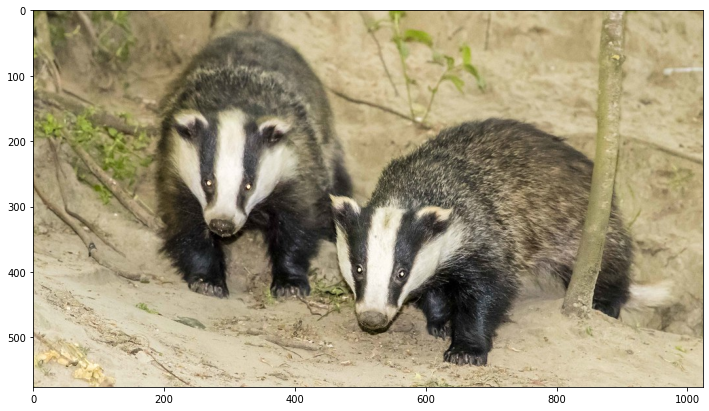

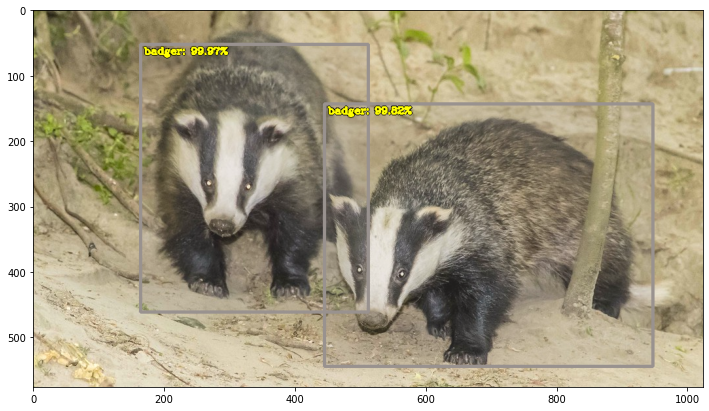

In [18]:
image = cv2.imread('test_img/badger2.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12,8))
plt.imshow(image)

out = image.copy()
image = cv2.resize(image, (300, 300))
image = np.expand_dims(image, axis=0)

output_list = [tf_scores, tf_boxes, tf_classes, tf_num_detections]
input_dict  = {tf_input: image}
predictions = tf_sess.run(output_list, feed_dict=input_dict)
scores, boxes, classes, num_detections = predictions

boxes = np.squeeze(boxes)                   # same as boxes[0], removes a dim
scores = np.squeeze(scores)                 # same as scores[0]
classes = np.squeeze(classes)               # same as classes[0]
num_detections = int(np.squeeze(num_detections)) # same as num_detections[0]


fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1, 1, 1)
# Show the original image
ax.imshow(out)

H, W = out.shape[:2]

categoryIdx = label_map_util.create_category_index(categories)
# plot boxes exceeding score threshold
for box, score, label in zip(boxes, scores, classes):
    if score < confidence:
        continue
    # scale box to image coordinates
    startY, startX, endY, endX = box

    # fix sizes and do some calculations
    startX      = int(startX * W)
    startY      = int(startY * H)
    endX        = int(endX * W)
    endY        = int(endY * H)
    w           = endX - startX
    h           = endY - startY
    start_point = (startX, startY) 
    end_point   = (endX, endY) 
    color_num   = categoryIdx[label]['id'] - 1
    color       = color_list[color_num] 

    # Display overlay
    # Enable line below and comment next ones if you only want a rectangle
    out = cv2.rectangle(out, start_point, end_point, color, 4)
    # Comment line above and uncomment below if you want only alpha blending
    rect = np.full((h,w,3),color, dtype='uint8')
    thickness   =  -1  # Fill
    alpha       = 0.8
    beta        = 1 - alpha
    crop        = out[startY:endY,startX:endX]
    cv2.addWeighted(crop, alpha, rect, beta, 0, crop)

    # display class index and score
    lbl = categoryIdx[label]['name']
    data = lbl + ': ' + str(np.round(score *100,2)) +'%'
    cv2.putText(out, data, (startX + 5, startY + 15), cv2.FONT_HERSHEY_COMPLEX, 0.5, (0,0,0), 3)
    cv2.putText(out, data, (startX + 5, startY + 15), cv2.FONT_HERSHEY_COMPLEX, 0.5, (255,255,0), 2)
plt.imshow(out)

### Benchmakr

Finally, benchmark over a sample batch of 100 pictures.

In [19]:
num_samples = 100

t0 = time.time()
for i in range(num_samples):
    scores, boxes, classes, num_detections = tf_sess.run([tf_scores, tf_boxes, tf_classes, tf_num_detections], feed_dict={
        tf_input: image
    })
t1 = time.time()
print('Average runtime: %f seconds' % (float(t1 - t0) / num_samples))

Average runtime: 0.007828 seconds


### Conclusion

When the CPU is selected, the benchmarks are around 100 ms or 10  FPS.

When the GPU is selected, the benchmarks are around 7.8 ms or 127 FPS.

Let's see what can we achieve on the Jetson Nano!